In [2]:
# Read JSON file

import json

json_file = 'output.json'
with open(json_file) as f:
    data = json.load(f)

print(data)

{'pages': [{'page_idx': 0, 'dimensions': [1511, 974], 'orientation': {'value': None, 'confidence': None}, 'language': {'value': None, 'confidence': None}, 'blocks': [{'geometry': [[0.1757952868326489, 0.0693359375], [0.31820296457905545, 0.1416015625]], 'lines': [{'geometry': [[0.1757952868326489, 0.0693359375], [0.31820296457905545, 0.0947265625]], 'words': [{'value': 'NISONAN', 'confidence': 0.20115308463573456, 'geometry': [[0.1757952868326489, 0.0693359375], [0.31820296457905545, 0.0947265625]], 'crop_orientation': {'value': 0, 'confidence': None}}]}, {'geometry': [[0.20003489155544146, 0.1142578125], [0.300023261036961, 0.1416015625]], 'words': [{'value': '*', 'confidence': 0.4606657326221466, 'geometry': [[0.20003489155544146, 0.1142578125], [0.300023261036961, 0.1416015625]], 'crop_orientation': {'value': 0, 'confidence': None}}]}], 'artefacts': []}, {'geometry': [[0.07126199146560575, 0.1923828125], [0.4318261117171458, 0.2470703125]], 'lines': [{'geometry': [[0.071261991465605

In [3]:
data["pages"][0].keys()

dict_keys(['page_idx', 'dimensions', 'orientation', 'language', 'blocks'])

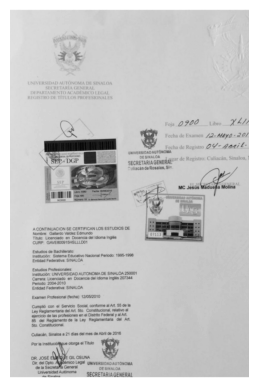

In [4]:
dimensions = data["pages"][0]["dimensions"]

import cv2
import requests
from matplotlib import pyplot as plt

img_path = "input.jpeg"
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Resize image

img = cv2.resize(img, (dimensions[1], dimensions[0]))

plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

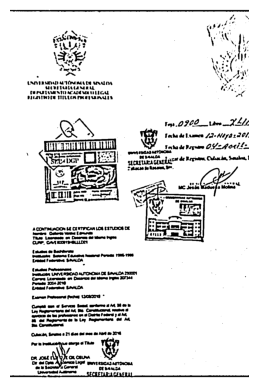

In [6]:
import cv2
import numpy as np


noise_removal = cv2.bilateralFilter(img, 9, 75, 75)

binary_image = cv2.adaptiveThreshold(noise_removal, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

plt.imshow(binary_image, cmap='gray')

plt.axis('off')
plt.show()


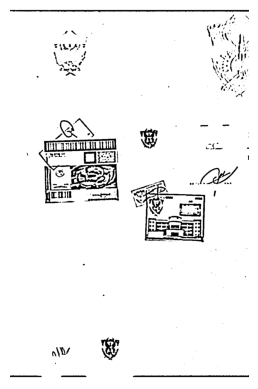

In [7]:
for block in data["pages"][0]["blocks"]:
    for word in block["lines"]:
        for word_data in word["words"]:
            xmin = int(word_data["geometry"][0][0] * img.shape[1])
            ymin = int(word_data["geometry"][0][1] * img.shape[0])
            xmax = int(word_data["geometry"][1][0] * img.shape[1])
            ymax = int(word_data["geometry"][1][1] * img.shape[0])
    
            binary_image[ymin:ymax, xmin:xmax] = 255

plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.show()


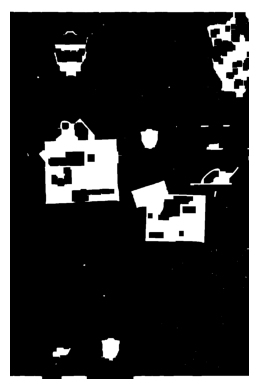

In [8]:
binary_image = cv2.bitwise_not(binary_image)

closing_kernel = np.ones((10, 10), np.uint8)
closing_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, closing_kernel, iterations=2)

plt.imshow(closing_image, cmap='gray')
plt.axis('off')
plt.show()

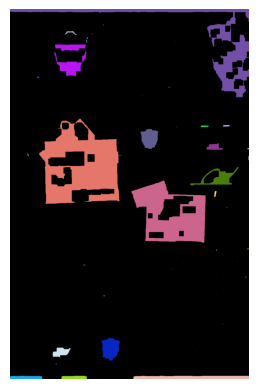

In [16]:
import cv2
import numpy as np

# Find connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing_image, connectivity=8)

# Create a blank RGB image to paint the connected components
output_image = np.zeros((binary_image.shape[0], binary_image.shape[1], 3), dtype=np.uint8)

# Generate random colors for each label
colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)

# Assign colors to each pixel based on its label
for y in range(labels.shape[0]):
    for x in range(labels.shape[1]):
        label = labels[y, x]
        if label != 0:  # Skip background (label 0)
            output_image[y, x] = colors[label]

# Display the output image
plt.imshow(output_image)
plt.axis('off')
plt.show()


Component 10 - Area: 17160, Width: 132, Height: 130
Component 19 - Area: 116928, Width: 336, Height: 348
Component 23 - Area: 5832, Width: 72, Height: 81
Component 26 - Area: 1876, Width: 67, Height: 28
Component 30 - Area: 14700, Width: 196, Height: 75
Component 32 - Area: 77216, Width: 304, Height: 254
Component 54 - Area: 6975, Width: 75, Height: 93
Component 55 - Area: 3066, Width: 73, Height: 42


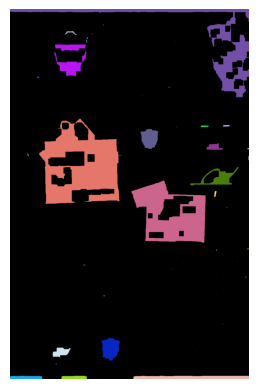

In [17]:
import cv2
import numpy as np

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing_image, connectivity=8)

img_area = img.shape[0] * img.shape[1]

img_dict = {} # Image : [[xmin, ymin, xmax, ymax], label]

import os
if not os.path.exists('crops'):
    os.makedirs('crops')

for label in range(1, num_labels): 
    
    width = stats[label, cv2.CC_STAT_WIDTH]
    height = stats[label, cv2.CC_STAT_HEIGHT]
    area = width * height
    
    if img_area*0.2> area > img_area*0.001 and  not (width / height > 4 or height / width > 4):
        print(f"Component {label} - Area: {area}, Width: {width}, Height: {height}")

        mask = np.uint8(labels == label)
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        x, y, w, h = cv2.boundingRect(contours[0])

        # Padding
        x -= 10
        y -= 10
        w += 20
        h += 20

        component_crop = img[y:y+h, x:x+w]

        cv2.imwrite(f'crops/component_{label}.png', component_crop)

        xmin = x / img.shape[1]
        ymin = y / img.shape[0]
        xmax = (x + w) / img.shape[1]
        ymax = (y + h) / img.shape[0]

        img_dict[f'crops/component_{label}.png'] = [[xmin, ymin, xmax, ymax], ""]

# Display the output image
plt.imshow(output_image)    
plt.axis('off')
plt.show()


In [56]:
img_dict

{'crops/component_10.png': [[0.17453798767967146,
   0.08934480476505625,
   0.33059548254620125,
   0.1886168100595632],
  ''],
 'crops/component_19.png': [[0.11190965092402463,
   0.2898742554599603,
   0.47741273100616016,
   0.5334215751158173],
  ''],
 'crops/component_23.png': [[0.5359342915811088,
   0.31767041694242226,
   0.6303901437371663,
   0.38451356717405694],
  ''],
 'crops/component_26.png': [[0.8121149897330595,
   0.3560555923229649,
   0.9014373716632443,
   0.3878226340172071],
  ''],
 'crops/component_30.png': [[0.74435318275154,
   0.4202514890800794,
   0.9661190965092402,
   0.4831237590999338],
  ''],
 'crops/component_32.png': [[0.49691991786447637,
   0.457313037723362,
   0.8295687885010267,
   0.6386499007279947],
  ''],
 'crops/component_54.png': [[0.37166324435318276,
   0.8821972203838517,
   0.46919917864476385,
   0.956982131039047],
  ''],
 'crops/component_55.png': [[0.16837782340862423,
   0.9086697551290536,
   0.26386036960985626,
   0.9497021839

# Segment Classification

In [18]:
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten

import os

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

import matplotlib.pyplot as plt
import numpy as np


class_to_label = {'BarCodes': 0, 'Graphs': 1, 'LogosAndStamps': 2, 'Photographs': 3, 'QRcodes': 4, 'Signatures': 5}
label_to_class = {v: k for k, v in class_to_label.items()}

num_classes = len(class_to_label)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.load_weights('model_weights.h5')

1/1 [==============================] - 0s 297ms/step


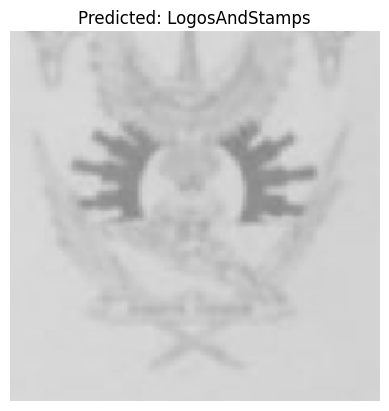

1/1 [==============================] - 0s 96ms/step


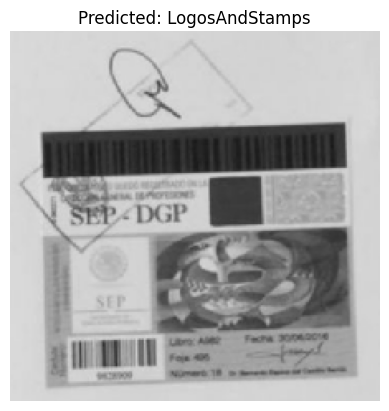

1/1 [==============================] - 0s 82ms/step


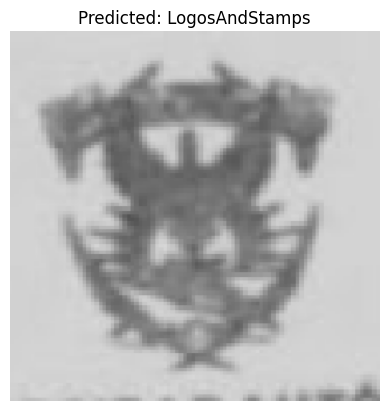

1/1 [==============================] - 0s 81ms/step


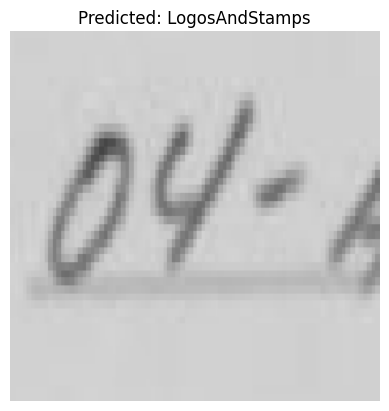

1/1 [==============================] - 0s 80ms/step


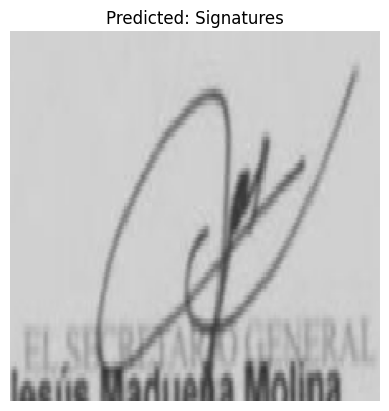

1/1 [==============================] - 0s 80ms/step


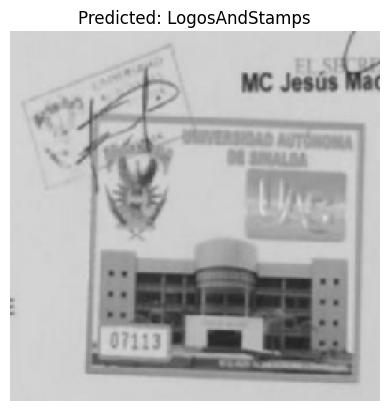

1/1 [==============================] - 0s 76ms/step


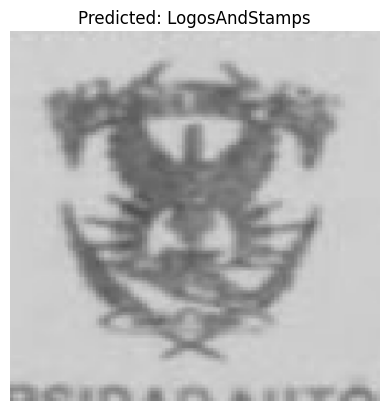

1/1 [==============================] - 0s 67ms/step


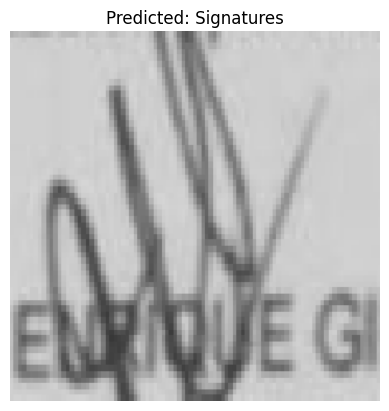

In [19]:
# Test the model with samples images

img_folder = r"crops/"



for file_name in os.listdir(img_folder):

    if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
        
        file_path = os.path.join(img_folder, file_name)
        img = image.load_img(file_path, target_size=(224, 224))

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)


        predictions = model.predict(x)
        predicted_labels = np.argmax(predictions, axis=1)

        labels = [label_to_class[label] for label in predicted_labels]
        
        # Modify the img_dict to include the predicted label

        img_dict[file_path][1] = labels[0]
        
        #confidence_scores = predictions[0]

        # Decode the results into a list of tuples (class, description, probability)
        #for i, score in enumerate(confidence_scores):
            #print(f"Class: {label_to_class[i]}, Confidence: {score:.4f}")


        plt.imshow(img)
        plt.title(f"Predicted: {labels[0]}")
        plt.axis('off')
        plt.show()

In [58]:
img_dict

{'crops/component_10.png': [[0.17453798767967146,
   0.08934480476505625,
   0.33059548254620125,
   0.1886168100595632],
  'LogosAndStamps'],
 'crops/component_19.png': [[0.11190965092402463,
   0.2898742554599603,
   0.47741273100616016,
   0.5334215751158173],
  'LogosAndStamps'],
 'crops/component_23.png': [[0.5359342915811088,
   0.31767041694242226,
   0.6303901437371663,
   0.38451356717405694],
  'LogosAndStamps'],
 'crops/component_26.png': [[0.8121149897330595,
   0.3560555923229649,
   0.9014373716632443,
   0.3878226340172071],
  'LogosAndStamps'],
 'crops/component_30.png': [[0.74435318275154,
   0.4202514890800794,
   0.9661190965092402,
   0.4831237590999338],
  'Signatures'],
 'crops/component_32.png': [[0.49691991786447637,
   0.457313037723362,
   0.8295687885010267,
   0.6386499007279947],
  'LogosAndStamps'],
 'crops/component_54.png': [[0.37166324435318276,
   0.8821972203838517,
   0.46919917864476385,
   0.956982131039047],
  'LogosAndStamps'],
 'crops/component_

In [59]:
def analyze_images(json_file, img_path, vgg_weights_path):

    # json_file - Path to JSON file containing the OCR output
    # img_path - Path to the input image
    # vgg_weights_path - Path to the VGG weights file

    img_dict = {} #  Function returns dict - > image : [[xmin, ymin, xmax, ymax], label] 

    # Detection of figures

    with open(json_file) as f:
        data = json.load(f)

    dimensions = data["pages"][0]["dimensions"]

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (dimensions[1], dimensions[0]))

    noise_removal = cv2.bilateralFilter(img, 9, 75, 75)
    binary_image = cv2.adaptiveThreshold(noise_removal, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 2)

    for block in data["pages"][0]["blocks"]:
        for word in block["lines"]:
            for word_data in word["words"]:

                xmin = int(word_data["geometry"][0][0] * img.shape[1])
                ymin = int(word_data["geometry"][0][1] * img.shape[0])
                xmax = int(word_data["geometry"][1][0] * img.shape[1])
                ymax = int(word_data["geometry"][1][1] * img.shape[0])

                binary_image[ymin:ymax, xmin:xmax] = 255

    binary_image = cv2.bitwise_not(binary_image)

    closing_kernel = np.ones((10, 10), np.uint8)
    closing_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, closing_kernel, iterations=2)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closing_image, connectivity=8)

    img_area = img.shape[0] * img.shape[1]

    import os
    if not os.path.exists('crops'):
        os.makedirs('crops')

    for label in range(1, num_labels): 
        
        width = stats[label, cv2.CC_STAT_WIDTH]
        height = stats[label, cv2.CC_STAT_HEIGHT]
        area = width * height
        
        if img_area*0.2> area > img_area*0.001 and  not (width / height > 4 or height / width > 4):
            print(f"Component {label} - Area: {area}, Width: {width}, Height: {height}")

            mask = np.uint8(labels == label)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            x, y, w, h = cv2.boundingRect(contours[0])
            
            # Padding
            x -= 10
            y -= 10
            w += 20
            h += 20
            component_crop = img[y:y+h, x:x+w]

            cv2.imwrite(f'crops/component_{label}.png', component_crop)

            xmin = x / img.shape[1]
            ymin = y / img.shape[0]
            xmax = (x + w) / img.shape[1]
            ymax = (y + h) / img.shape[0]

            img_dict[f'crops/component_{label}.png'] = [[xmin, ymin, xmax, ymax], ""]


    # Classify cropped images
    
    class_to_label = {'BarCodes': 0, 'Graphs': 1, 'LogosAndStamps': 2, 'Photographs': 3, 'QRcodes': 4, 'Signatures': 5}

    num_classes = len(class_to_label)

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.load_weights(vgg_weights_path)

    img_folder = r"crops/"

    for file_name in os.listdir(img_folder):

        if file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):

            file_path = os.path.join(img_folder, file_name)
            img = image.load_img(file_path, target_size=(224, 224))

            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)

            predictions = model.predict(x)
            predicted_labels = np.argmax(predictions, axis=1)

            labels = [label_to_class[label] for label in predicted_labels]

            img_dict[file_path][1] = labels[0]

    
    return img_dict


In [60]:
dict_output = analyze_images('output.json', 'input.jpeg', 'model_weights.h5')

Component 10 - Area: 17160, Width: 132, Height: 130
Component 19 - Area: 116928, Width: 336, Height: 348
Component 23 - Area: 5832, Width: 72, Height: 81
Component 26 - Area: 1876, Width: 67, Height: 28
Component 30 - Area: 14700, Width: 196, Height: 75
Component 32 - Area: 77216, Width: 304, Height: 254
Component 54 - Area: 6975, Width: 75, Height: 93
Component 55 - Area: 3066, Width: 73, Height: 42
1/1 [==============================] - 0s 64ms/step


In [61]:
dict_output 

{'crops/component_10.png': [[0.17453798767967146,
   0.08934480476505625,
   0.33059548254620125,
   0.1886168100595632],
  'LogosAndStamps'],
 'crops/component_19.png': [[0.11190965092402463,
   0.2898742554599603,
   0.47741273100616016,
   0.5334215751158173],
  'LogosAndStamps'],
 'crops/component_23.png': [[0.5359342915811088,
   0.31767041694242226,
   0.6303901437371663,
   0.38451356717405694],
  'LogosAndStamps'],
 'crops/component_26.png': [[0.8121149897330595,
   0.3560555923229649,
   0.9014373716632443,
   0.3878226340172071],
  'LogosAndStamps'],
 'crops/component_30.png': [[0.74435318275154,
   0.4202514890800794,
   0.9661190965092402,
   0.4831237590999338],
  'Signatures'],
 'crops/component_32.png': [[0.49691991786447637,
   0.457313037723362,
   0.8295687885010267,
   0.6386499007279947],
  'LogosAndStamps'],
 'crops/component_54.png': [[0.37166324435318276,
   0.8821972203838517,
   0.46919917864476385,
   0.956982131039047],
  'LogosAndStamps'],
 'crops/component_

: 